# X-Ray Prohibit Object Detection
## Notebook

### Project By:

> Andy Huang (z5311916) \
> Boyang He(z5575322)\
> Yizhu Zhou (z5602082)\
> Yuanyuan Zhang\
> Yuxuan Wang

## Summary
1. Introduction
    - 1.1 Problem Statement
    - 1.2 Motivation
2. Data Source
3. Exploratory Data Analysis
    - 3.1 Load Annotations and Preview
    - 3.2 Dataset Statistics: Category Distribution
    - 3.3 Fix Negative Bounding Box Values
    - 3.4 Image Resolution Analysis
    - 3.5 Class Imbalance Assessment
    - 3.6 Visualize One Bounding Box per Category
    - 3.7 Occlusion Level Distribution
4. Models and Methods
    - 4.1 Yolo v8
    - 4.2 Faster R-CNN
    - 4.3 sjdflkjsdlkfjsdlkjflkdsjflksdjflkjsdlkfjsldkjflksdjfkljsdlkfjsdlkjflsdkjflksdjflkjsdlkfjsdlkjflkdsjflskjflksd
    - 4.4 sjdflkjsdlkfjsdlkjflkdsjflksdjflkjsdlkfjsldkjflksdjfkljsdlkfjsdlkjflsdkjflksdjflkjsdlkfjsdlkjflkdsjflskjflksd
5. Results
    - 5.1 Yolo v8 results
    - 5.2 Faster R-CNN results
    - 5.3 sjdflkjsdlkfjsdlkjflkdsjflksdjflkjsdlkfjsldkjflksdjfkljsdlkfjsdlkjflsdkjflksdjflkjsdlkfjsdlkjflkdsjflskjflksd
    - 5.4 sjdflkjsdlkfjsdlkjflkdsjflksdjflkjsdlkfjsldkjflksdjfkljsdlkfjsdlkjflsdkjflksdjflkjsdlkfjsdlkjflkdsjflskjflksd
6. Discussion
    - 6.1 Result Summary
    - 6.2 Multi-model performance comparison
7. Conclusion
    - 7.1 Further Improvement

## 1. Introduction

### 1.1 Problem statement

#### With the increasing population density in public transportation, it is important to ensure the safety of passengers. X-ray scanners are used by the security personnel to detect prohibited items in passengers' baggage. However, the random stacking and significant overlap of objects within luggage create severe visual occlusion, making it difficult for trained inspectors to accurately identify threats.

#### In recent years, object detection techniques based on deep learning have shown promising results in recent years. Unlike traditional hand-crafted feature-based methods, deep neural networks can automatically learn hierarchical visual patterns and perfomance well to complex scenarios.

### 1.2 Motivation

#### The goal of this project is to develop a fast and accurate neural network model for X-ray image object detection. By leveraging advanced object detection algorithms and optimizing them for the X-ray domain, this project aims to improve detection precision and robustness under heavy occlusion, which can provide intelligent assistence to security personnel to improve the security of public transportation.

## 2. Data Sources

#### This project uses the OPIXray-v2 dataset. It is a benchmark dataset designed for prohibited item detection in X-ray security imagery. The dataset contains a total of 8,885 X-ray images. There are five categories of prohibited items in the dataset: Straight_Knife, Folding_Knife, Scissor, Utility_Knife and Multi-tool_Knife. Each image has a annotated text file, containing bounding boxes indicating the locations and categories of the prohibited items.

#### Dataset URL: 
#### (https://github.com/OPIXray-author/OPIXray/)


## 3. Exploratory Data Analysis

### 3.1 Load Annotations and Preview
The dataset consists of 7,139 annotated samples. Each annotation contains the image path, object category, and a bounding box represented by four coordinates `[x_min, y_min, x_max, y_max]`. Below are the first few rows for preview.

In [1]:

import os
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

annotation_dir = 'dataset/train/train_annotation'
image_dir = 'dataset/train/train_image'

data_list = []

for txt_file in os.listdir(annotation_dir):
    if txt_file.endswith('.txt'):
        txt_path = os.path.join(annotation_dir, txt_file)
        with open(txt_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 6:
                    image_name = parts[0]
                    label = parts[1]
                    bbox = [int(x) for x in parts[2:6]]
                    image_path = os.path.join(image_dir, image_name)
                    data_list.append((image_path, label, bbox))

df = pd.DataFrame(data_list, columns=['image_path', 'label', 'bbox'])
print(f"Total number of samples: {len(df)}")
df.head(3)


Total number of samples: 7139


,image_path,label,bbox
0,dataset/train/train_image/037398.jpg,Multi-tool_Knife,"[463, 363, 556, 429]"
1,dataset/train/train_image/042061.jpg,Folding_Knife,"[523, 397, 653, 543]"
2,dataset/train/train_image/041568.jpg,Multi-tool_Knife,"[500, 503, 565, 626]"


### 3.2 Dataset Statistics: Category Distribution
There are five object categories in the dataset. Their distribution is as follows:

- Utility_Knife: 1,635 samples  
- Multi-tool_Knife: 1,612 samples  
- Folding_Knife: 1,589 samples  
- Scissor: 1,494 samples  
- Straight_Knife: 809 samples

The class distribution is relatively even for four categories, but **Straight_Knife** is underrepresented with only half the number of samples compared to the most frequent class.

Number of samples per category:
label
Utility_Knife       1635
Multi-tool_Knife    1612
Folding_Knife       1589
Scissor             1494
Straight_Knife       809
Name: count, dtype: int64


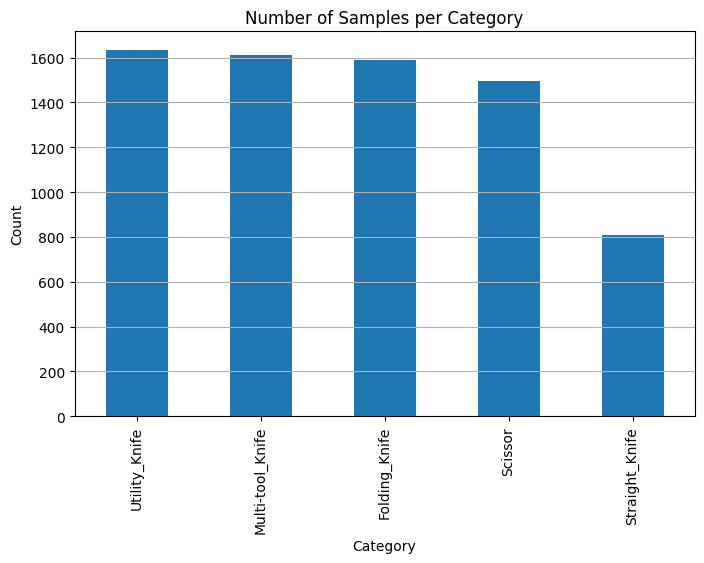

In [2]:

category_counts = df['label'].value_counts()
print("Number of samples per category:")
print(category_counts)

plt.figure(figsize=(8,5))
category_counts.plot(kind='bar')
plt.title('Number of Samples per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()


### 3.3 Fix Negative Bounding Box Values
We checked the dataset for any negative values in the bounding boxes. All coordinates were valid, and no negative values were found in the sample preview. A function was applied to replace negative values with 0 as a precautionary step.

In [3]:

def fix_bbox(bbox):
    return [max(0, x) for x in bbox]

df['fixed_bbox'] = df['bbox'].apply(fix_bbox)

print("Original bbox:", df['bbox'].iloc[0])
print("Fixed bbox:   ", df['fixed_bbox'].iloc[0])


Original bbox: [463, 363, 556, 429]
Fixed bbox:    [463, 363, 556, 429]


### 3.4 Image Resolution Analysis
All images in the dataset have consistent resolution: **1225 x 954 pixels**. This consistency eliminates the need for resizing or padding during preprocessing and helps simplify model input pipeline.

### 3.5 Class Imbalance Assessment
The percentage of each category in the dataset is as follows:

- Utility_Knife: 22.9%
- Multi-tool_Knife: 22.6%
- Folding_Knife: 22.3%
- Scissor: 20.9%
- Straight_Knife: 11.3%

The class imbalance ratio (max/min) is **2.02**, indicating **moderate imbalance**. While not extreme, this may still influence model performance and can be addressed through techniques like data augmentation or class weighting.

In [6]:

category_percentage = category_counts / category_counts.sum() * 100
print("Category percentages:")
print(category_percentage)

imbalance_ratio = category_counts.max() / category_counts.min()
print(f"Class imbalance ratio (max/min): {imbalance_ratio:.2f}")


Category percentages:
label
Utility_Knife       22.902367
Multi-tool_Knife    22.580193
Folding_Knife       22.258019
Scissor             20.927301
Straight_Knife      11.332119
Name: count, dtype: float64
Class imbalance ratio (max/min): 2.02


### 3.6 Visualize One Bounding Box per Category
To better understand the dataset and annotation quality, we visualize one bounding box for each category.

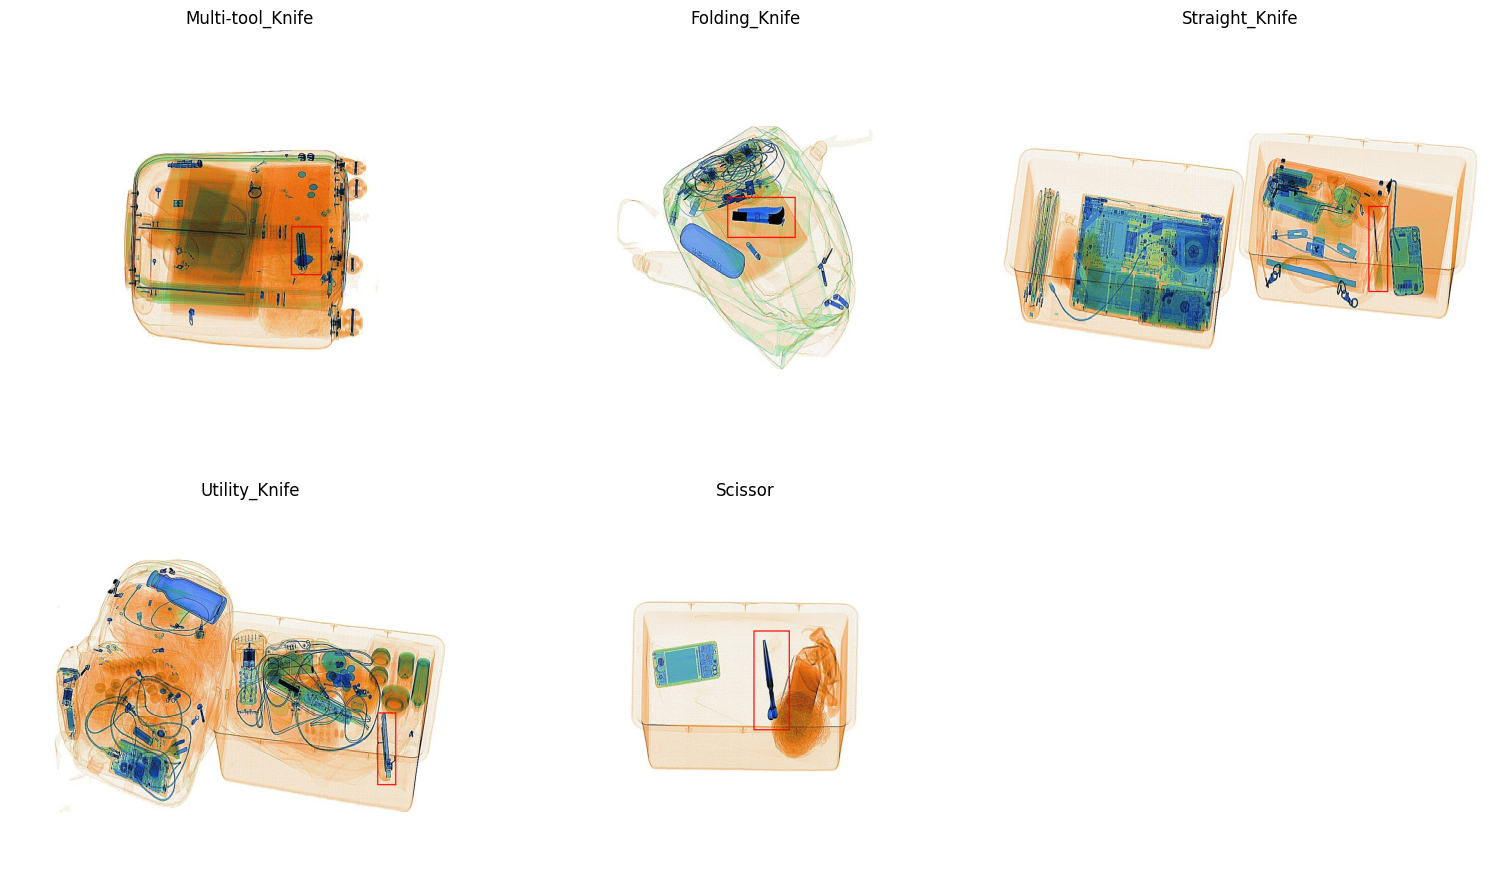

In [7]:

import random

plt.figure(figsize=(15, 10))
unique_labels = df['label'].unique()

for i, label in enumerate(unique_labels):
    sample = df[df['label'] == label].sample(1).iloc[0]
    img = Image.open(sample['image_path']).convert("RGB")
    draw = ImageDraw.Draw(img)
    bbox = sample['fixed_bbox']
    draw.rectangle(bbox, outline="red", width=3)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()


### 3.7 Occlusion Level Distribution (Test Set)

The test set is manually divided into three occlusion levels using separate annotation lists:

- **OL1**: No or Slight Occlusion (test_knife-1.txt)
- **OL2**: Partial Occlusion (test_knife-2.txt)
- **OL3**: Severe or Full Occlusion (test_knife-3.txt)

The following chart shows the number of test images in each occlusion level.


Number of images in each occlusion level:
OL1 (No/Slight): 922
OL2 (Partial): 548
OL3 (Severe/Full): 306


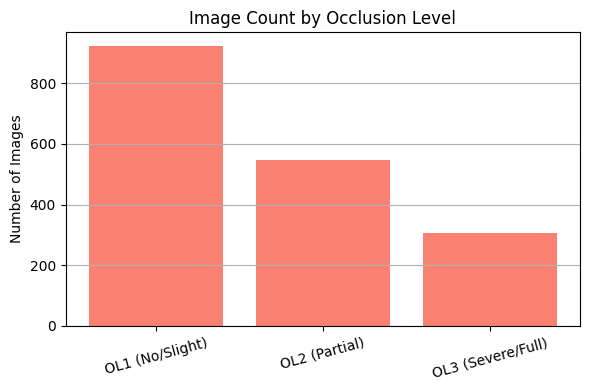

In [ ]:
import os
import matplotlib.pyplot as plt

# Set the directory containing the test images
test_dir = 'dataset/test'

# map the occlusion levels to their corresponding file names
occlusion_files = {
    'test_knife-1.txt': 'OL1 (No/Slight)',
    'test_knife-2.txt': 'OL2 (Partial)',
    'test_knife-3.txt': 'OL3 (Severe/Full)'
}

occlusion_counts = {}

for file_name, level_name in occlusion_files.items():
    file_path = os.path.join(test_dir, file_name)
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            lines = f.readlines()
            occlusion_counts[level_name] = len(lines)
    else:
        print(f"File not found: {file_path}")
        occlusion_counts[level_name] = 0

# print the counts for each occlusion level
print("Number of images in each occlusion level:")
for level, count in occlusion_counts.items():
    print(f"{level}: {count}")

# plotting the occlusion levels
labels = list(occlusion_counts.keys())
counts = list(occlusion_counts.values())

plt.figure(figsize=(6,4))
plt.bar(labels, counts, color='salmon')
plt.title("Image Count by Occlusion Level")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [ ]:
import os
from collections import defaultdict
import pandas as pd
from IPython.display import display

# Set the base directory and annotation directory
base_dir = 'dataset/test'
anno_dir = os.path.join(base_dir, 'test_annotation')
occlusion_files = {
    'OL1': 'test_knife-1.txt',
    'OL2': 'test_knife-2.txt',
    'OL3': 'test_knife-3.txt'
}

occlusion_category_count = defaultdict(lambda: defaultdict(int))

for occlusion_level, filename in occlusion_files.items():
    with open(os.path.join(base_dir, filename), 'r') as f:
        image_ids = [line.strip() for line in f.readlines()]
    
    for img_id in image_ids:
        anno_file = os.path.join(anno_dir, f"{img_id}.txt")
        if not os.path.exists(anno_file):
            continue
        with open(anno_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    label = parts[1]
                    occlusion_category_count[occlusion_level][label] += 1

df = pd.DataFrame(occlusion_category_count).fillna(0).astype(int).T
df["Total"] = df.sum(axis=1)
df.loc["Total"] = df.sum()
display(df)


,Straight_Knife,Scissor,Utility_Knife,Multi-tool_Knife,Folding_Knife,Total
OL1,88,160,214,255,206,923
OL2,84,125,88,105,148,550
OL3,63,83,41,70,50,307
Total,235,368,343,430,404,1780


## 4. Models and Methods

### 4.1 Yolo v8

#### While the dataset itself was already annotated with object labels and bounding box coordinates, the original annotation format was incompatible with the YOLOv8 training pipeline. Therefore, a comprehensive data pre-processing step was required to adapt the dataset into YOLO format.
#### Our original annotation files contained entries in the form: `<ImageName> <ClassName> <x1> <y1> <x2> <y2>`
#### In order to convert it into YOLO format <class_id> <x_center> <y_center> <width> <height>

1. **We read each annotation line** and extract the image name, class name, and bounding box coordinates `(x1, y1, x2, y2)`.
2. **Then we convert the class name** into its integer ID using a predefined class map.
3. **After that we load the image** using `cv2.imread()` to get `width` and `height`.
4. **Then we normalize bounding box**:
   - `x_center = (x1 + x2) / 2 / w`
   - `y_center = (y1 + y2) / 2 / h`
   - `width = (x2 - x1) / w`
   - `height = (y2 - y1) / h`
5. **Save labels** to `.txt` files in YOLO format.
6. **Copy the image** to the corresponding `/images/train` or `/images/val` folder.


This ensured that each image had a matching YOLO-formatted label file, making the dataset fully compatible with YOLOv8 training procedures.

In [1]:
from ultralytics import YOLO
import torch

# Load the final model from training
model = YOLO("best.pt") 

# get the model architecture
net = model.model

# Count the number of parameters and layers in the model
total_params = sum(p.numel() for p in net.parameters())


print(f"\nTotal parameters: {total_params:,}")
print(f"Total layers: {len(list(net.modules()))}")



Total parameters: 3,011,823
Total layers: 225


#### Yolo Model Overview

We use **YOLOv8n (nano)**, a lightweight pretrained deep learning model which is suitable for real-time object detection and prediction.  
It is a **fully convolutional neural network (CNN)** consisting of three main components:

- **Backbone**: Extracts multi-level semantic features from the input image, such as edges, textures, and object structures.

- **Neck**: Fuses features from different scales to enhance the model's ability to detect both large and small objects.

- **Head**: Predicts object locations (bounding boxes) and class labels based on the feature maps, and compares them with ground truth annotations to compute the loss.

The entire process is optimized during training through **backpropagation** to improve detection accuracy.

The model has 3,011,823 and 225 layers.We trained the YOLOv8n (nano) version using our preprocessed dataset with standard configurations. The model was trained on a NVIDIA RTX 3070 GPU for 10 epochs with an image size of 640 and batch size of 16.And it took one hour and a half to finish the training.


### 4.2 Faster R-CNN

###### *Faster R-CNN has two main notebook: CNN.ipynb and CNN_loading.ipynb. CNN.ipynb contains how the model is trained. While CNN_loading.ipynb contains how the model is loaded, evaluated and how to predict the image.*

#### Faster R-CNN: we use a pre-trained Faster R-CNN model with a ResNet-50 backbone for the object detection. Then, perform a task-specific training on our dataset to adjust the model to the X-ray prohibited items detection domain.

#### Faster R-CNN is a two-stage detector. It first generates region proposals, then classifies and refines them. The ResNet-50 network serves as the feature extractor, which is used to capture image semantic information. The reason to choose ResNet-50 is that it performs well on detecting overlapping and occluded objects, which is crucial for the X-ray security detection in real life. 

#### The architecture of this model have three main parts: the backbone (ResNet-50), the feature pyramid network (FPN), and the region proposal.
1. The input layer accept and resize the images.
2. The ResNet-50 with 50 layers and is responsible for extracting hierarchical semantic features from the input image.
3. The RPN then proposes candidate object regions based on the FPN features.
4. Finally, the RoI heads classify the proposed regions and refine the bounding boxes.

#### This two-stage pipeline allows the model to locate and classify objects efficiently. During training, the loss is calculated from classification, box regression, and RPN proposals. Our training loop runs for 10 epochs, optimizing the model using backpropagation.


## 5 Results

### the average detection accuracy across all categories

| Occlusion level | precision | IoU>0.5 ratio | mAP50 |
|-----------------|-----------|---------------|--------|
| **Yolo 8**       |           |               |        |
| Level 1         | 0.8671    | 0.93471       | 0.8853 |
| Level 2         | 0.8525    | 0.9325        | 0.8690 |
| Level 3         | 0.8525    | 0.9310        | 0.8112 |
| overall         | 0.8666    | 0.9347        | 0.8468 |
| **EfficientDet** |           |               |        |
| Level 1         | 0.8813    | 0.5477        | 0.8813 |
| Level 2         | 0.8649    | 0.5255        | 0.8649 |
| Level 3         | 0.8964    | 0.5654        | 0.8964 |
| overall         | 0.8790    | 0.5439        | 0.8790 |
| **Faster R-CNN** |           |               |        |
| Level 1         | 0.8670    | 0.8711        | 0.7034 |
| Level 2         | 0.8108    | 0.8291        | 0.6820 |
| Level 3         | 0.7770    | 0.7622        | 0.6481 |
| overall         | 0.8351    | 0.8393        | 0.6861 |
| **RetinaNET** |           |               |        |
| Level 1         | 0.8840    | 0.8351        | 0.7822 |
| Level 2         | 0.8940    | 0.8157        | 0.7692 |
| Level 3         | 0.8913    | 0.8039        | 0.7477 |
| overall         | 0.8883    | 0.8238        | 0.7705 |


##### *This table is collected from each of our notebooks.*

### 5.1 YOLO v8


image 1/1 d:\STUDY_UNSW\2025T1\COMP9444_DL_Neural_Network\Team_project\Project\Dataset\images\test_0\024119.jpg: 512x640 1 Scissor, 42.0ms
Speed: 11.9ms preprocess, 42.0ms inference, 19.6ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs\detect\predict10


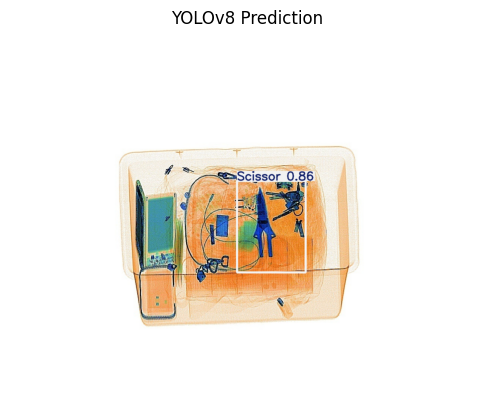

In [2]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
# Set the path to the model
model = YOLO("runs/detect/train9/weights/best.pt")

image_path = "Dataset/images/test_0/024119.jpg"
# predict using the model
results = model.predict(source=image_path, save=True, conf=0.25)

# Show the results
img = cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes
plt.imshow(img)
plt.axis('off')
plt.title("YOLOv8 Prediction")
plt.show()

#### YOLOv8 Detection Result

The model detects a **Scissor** with **86% confidence**, shown by the white bounding box and label.  
This demonstrates YOLOv8's effectiveness in identifying restricted items in X-ray baggage scans, even under occlusion — making it ideal for airport and station security applications.


YOLOv8n achieves strong overall performance, with precision of 0.8666 and mAP@0.5 of 0.8468, indicating that the model can accurately detect and classify most knife types.

Its IoU > 0.5 ratio reaches 0.9347, significantly higher than EfficientDet (0.5439), Faster R-CNN (0.8393), and FCOS (0.8430). This metric reflects the proportion of predictions that closely overlap with ground truth boxes, showing that YOLOv8n provides high accuracy in knife detection.

Compared to other models, YOLOv8n is faster, easier to deploy, and more robust under varying occlusion levels, making it highly suitable for real-time applications.This aligns well with practical use cases such as airport and railway station security, where rapid deployment and efficient object detection are essential.

   Class Index        Class Name  Precision    Recall        F1     mAP50
0            0    Straight_Knife   0.800402  0.580185  0.672730  0.709352
1            1     Folding_Knife   0.845588  0.886139  0.865388  0.914923
2            2           Scissor   0.989036  0.980499  0.984749  0.989107
3            3     Utility_Knife   0.818639  0.810496  0.814547  0.825766
4            4  Multi-tool_Knife   0.879424  0.913953  0.896356  0.934389


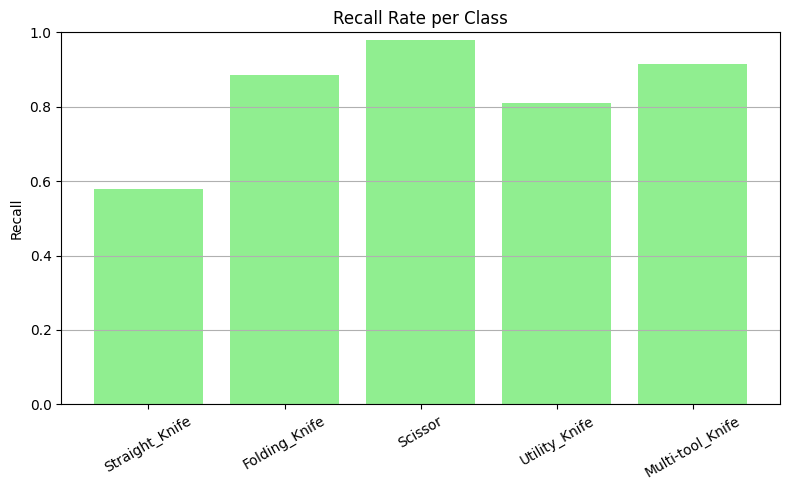

In [3]:
import pandas as pd


# Read the file
df = pd.read_csv("Dataset/test_0_results.csv")

# print the file
print(df)


# Plot the recall rate per class
plt.figure(figsize=(8, 5))
plt.bar(df["Class Name"], df["Recall"], color='lightgreen')
plt.title("Recall Rate per Class")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


#### Per-Class Analysis

Amoung most classes, the model achieves both high precision and recall, indicating a strong ability to detect and correctly classify various types of knives.  
In particular, the performance on the **Scissor** class is outstanding, with an **F1-score of 0.9847** and **mAP@50 of 0.9891**, suggesting highly consistent and accurate predictions.  
This can be attributed to the distinct visual characteristics of scissors (e.g., thin elongated blades, symmetrical shape), which make them easier for the model to extract features and detect.

However, for the **Straight_Knife** class, recall drops significantly to **0.580**, indicating that a large portion of ground truth objects were missed during prediction.  
This may be due to multiple factors:

- **Smaller training sample size**: *Straight_Knife* had the fewest labeled instances (**809 samples before train/val split**), reducing the model's exposure to this category during training.
- **Data split reduction**: After splitting into training and validation sets, the actual training data for this class became even more limited.
- **Model misclassification rate**: As reported earlier in our analysis (*YOLOv8.ipynb*), the overall **missing classification rate is approximately 0.12**, which likely affected *Straight_Knife* more severely due to its lower representation.

These factors combined may have led the model to either misclassify *Straight Knives* or fail to detect them entirely.

In the future, we can leverage techniques such as reinforcement learning or data augmentation strategies (e.g., rotation, scaling, and zooming) to enrich the training set and further improve the model's robustness and generalization ability.


### 5.2 Faster R-CNN

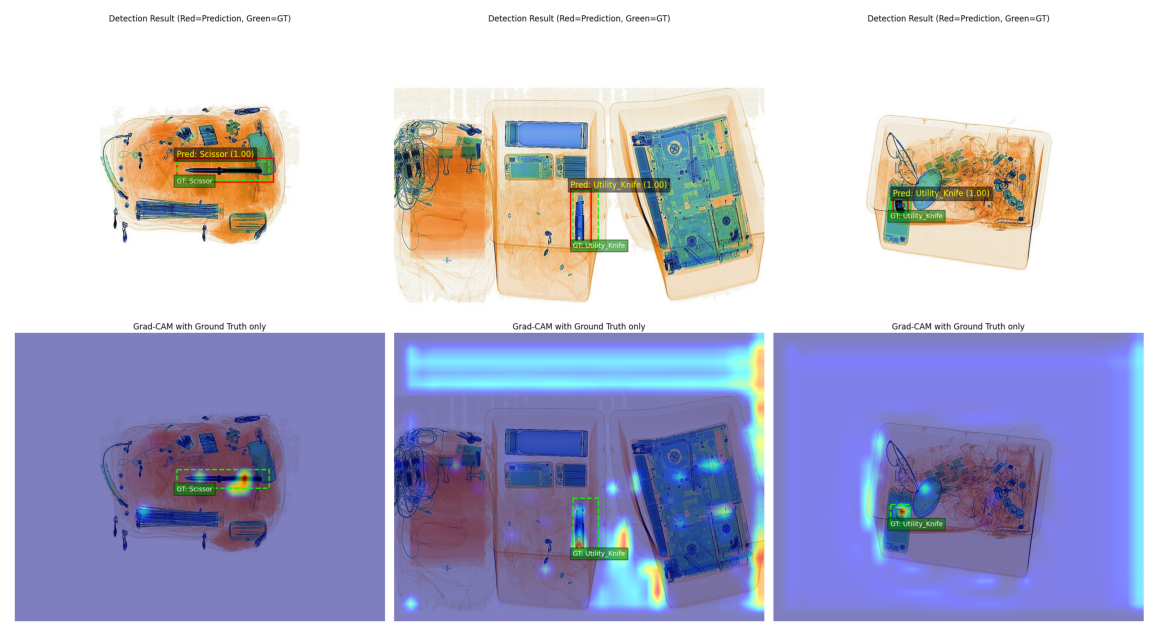

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(24, 8))  
img = mpimg.imread('R-CNN.png')
plt.imshow(img)
plt.axis('off')
plt.show()


#### The image above shows successful cases where the model correctly classified and localized prohibited items.From the corresponding Grad-CAM visualizations, we can observe that the model focuses on the core regions of the prohibited objects. For instance, in correctly classified samples such as Scissor and Utility_Knife, the heatmaps are concentrated on critical parts like the blade and handle, which indicates that the model has learned to recognize key discriminative features.

#### In addition, the model demonstrates accurate bounding box localization, with predicted boxes closely overlapping the ground truth boxes. This suggests the model is capable of precise detection, even in cluttered scenarios such as overlapping luggage environments. Furthermore, for those prohibited item classes with a sufficient number of training samples, the model performs well in both classification and detection, which indicates that it has successfully learned robust and stable feature information for these categories.

#### 5.2.1 Faster R-CNN weakness

| Class             | Precision | Recall  | F1 Score | Mean IoU |
|------------------|-----------|---------|----------|-----------|
| Straight_Knife   | 0.0000    | 0.0000  | 0.0000   | 0.6540    |
| Folding_Knife    | 0.8930    | 0.8465  | 0.8691   | 0.7186    |
| Scissor           | 0.9061    | 0.9701  | 0.9370   | 0.7568   |
| Utility_Knife    | 0.7111    | 0.8251  | 0.7638   | 0.7324    |
| Multi-tool_Knife | 0.8333    | 0.9070  | 0.8686   | 0.7164    |

###### *Can be found in the bottom of CNN_loading.ipynb*

#### From the table above, we can see that the class [Straight_Knife], the model has a precision, recall, and F1 score of 0.000, but the mean IoU is not 0. This indicates that none of the detected bounding boxes for this category were misclassified , even if the objects may have been detected.
 
#### There are several reasons resulting this. One biggest resason is that, [Straight_Knife] only has half number of taining images compared to other knife categories. Due to this unbalanced trainingset, the model may not have received enough gradient updates to learn effective feature representations for this class during training. The other reason is that, the model relies on convolutional feature maps extracted by ResNet50. And the visual patterns of the Straight_Knife class are not sufficiently distinctive from other knife classes. Given that the dataset contains multiple visually similar knife types mixed in the luggle X-ray images, the model confuses Straight_Knife with other knives.

## 6. Discussion


### 6.1 Result Summary

####  In our study, we took Faster R-CNN as the baseline of the traditional detection model and systematically evaluated the recognition ability of modern object detection models such as YOLOv8, EfficientDet, and RetinaNet for prohibited items under occlusion conditions. The experiment was trained using the same training set, and there was a certain category imbalance in the data (for example, the number of Straight Knives was significantly less than that of all other labels). On this basis, the robustness, accuracy and generalization ability of each model under different occlusion levels were compared.


### 6.2 Multi-model performance comparison

#### From the perspective of overall indicators, EfficientDet performs best in terms of mAP50 (0.8790) and average accuracy (0.8790), and remains stable under all occlusion levels. It still achieved a mAP of 0.8964 under Level 3 occlusion, showing good robustness. This is partly attributed to the multi-scale feature fusion mechanism of EfficientDet and the lightweight and efficient backbone. Meanwhile, it has integrated the DOAM (Dual-Order Attention Module) structure, giving the model an inherent advantage in detail extraction.

#### The IoU>0.5 hit rate of YOLOv8 is the highest among all models (0.9347), especially performing robustly at Level 1 and Level 2 (with maps reaching 0.8853 and 0.8690 respectively). Although the mAP dropped to 0.8112 under Level 3 occlusion, the overall detection accuracy remained relatively good. The anchor-free design and powerful semantic learning ability of YOLOv8 enable it to still provide high-quality detection results when facing complex occlusions and object deformations.

#### In contrast, the overall performance of Faster R-CNN as the baseline is significantly lower. Especially under the condition of Level 3, the mAP is only 0.6481. Limited by the category imbalance (for example, the sample size of the Straight Knife is relatively small), the model almost completely fails in the detection of this category. Furthermore, as a two-stage model, Faster R-CNN is particularly sensitive to occlusion during the process of feature extraction and RoI matching, failing to effectively capture complex context information, resulting in its overall performance being inferior to other modern models.

#### RetinaNet performs stably under all occlusion levels, especially in the Scissor category, with an average AP of over 0.94 and a Precision exceeding 0.90. This is mainly attributed to the mitigating effect of its Focal Loss mechanism on class imbalance. However, its performance is still limited in structurally simple and confusing categories such as Straight Knife, and the AP is often lower than 0.55. The Grad-CAM analysis shows that this model often focuses on the entire package area rather than the object itself during detection, indicating that it relies heavily on context information, which may lead to false detection or inaccurate positioning.

#### Referring to the existing literature, DOAM (Dual-Order Attention Module) enhances the model's ability to pay attention to local details by introducing the channel and spatial attention mechanism, and is particularly suitable for complex occlusion and multi-object scenarios. Adding DOAM to models such as SSD, YOLOv3 and FCOS has brought significant performance improvements (for example, YOLOv3 has increased to 79.25 mAP), especially in the Scissor and Multi-tool categories, the effects are remarkable.

#### Overall, the overall performance of YOLOv8 (mAP50 = 0.8468) has surpassed that of YOLOv3+DOAM, indicating that its own structure has a strong spatial modeling capability. EfficientDet itself integrates a similar attention mechanism and maintains high performance under multiple occlusion levels, further verifying the effectiveness of DOAM-like mechanisms in enhancing the robustness of the model.

## 7. Conclusion

#### Our work systematically evaluated the detection performance of multiple object detection models such as YOLOv8, EfficientDet, RetinaNet, and Faster R-CNN for prohibited items like knives in X-ray images under complex occlusion scenarios. The results show that YOLOv8 and EfficientDet perform the best. Their overall accuracy and robustness both exceed those of traditional models introducing DOAM (such as YOLOv3 and FCOS), verifying the significant progress of modern detection frameworks in feature modeling and semantic awareness. RetinaNet has initially alleviated the category imbalance problem with the help of Focal Loss and achieved a high detection accuracy rate on multiple tool categories. However, Faster R-CNN, as a baseline model, performs significantly limited in categories with severe occlusion or uneven sample sizes (such as Straight Knife), reflecting the limitations of traditional methods in complex scenarios.
#### Overall, this study not only demonstrates the differential performance of various detection models in the tool recognition task, but also provides a valuable reference for the security inspection system to select a more efficient and robust detection architecture in the actual deployment. The proposed evaluation methods and analysis results are expected to provide a certain degree of technical support and model basis for modern security inspection measures in the development direction of automation and intelligence.

### 7.1 Further Improvement

#### Training strategies for alleviating class inequality:
Introduce data augmentation methods such as MixUp and CutMix to enhance the model's learning ability for a few categories (such as Straight Knife) and alleviate the category bias problem during training.

#### Integrate multi-model prediction to enhance robustness:
Combining the prediction results of models such as YOLOv8, ResNet and Faster R-CNN, and through integrated voting or fusion strategies, the stability and overall accuracy of the models in complex scenarios are improved.

#### Introduce the attention mechanism to enhance feature focusing:
Integrating modules such as CBAM or SE Block into the network structure and guiding the model to focus on key areas is conducive to improving the detection effect under occlusion or complex background conditions.

#### Expand multimodal and self-supervised learning capabilities:
Enhance the category expansion capability by leveraging image and text joint modeling frameworks such as CLIP, and simultaneously conduct self-supervised pre-training on large-scale unlabeled data to strengthen the model's generalization ability for unknown samples and objects with weak features.